## Predict 3P/4L EoS

In [6]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
plt.rcParams.update({'font.size': 20})

### 1. Load data from file and prepare for training

Load the EoS and the $M-R$ curves from processed 3P/4L data files, then merge 3P and 4L data.

In [2]:
# Load the un-normalized data.
R_3p = np.loadtxt('../data/m-r_3p.txt')
P_3p = np.loadtxt('../data/eos_3p.txt')
R_4l = np.loadtxt('../data/m-r_4l.txt')
P_4l = np.loadtxt('../data/eos_4l.txt')

# Merge 3P and 4L data
R = np.concatenate((R_3p, R_4l))
P = np.concatenate((P_3p, P_4l))

Next, normalize the data, then shuffle the data and perform a train-test-validation split as 80-15-5.

In [3]:
# Normalize the data
r = (R - np.min(R)) / (np.max(R) - np.min(R))
p = (P - np.min(P)) / (np.max(P) - np.min(P))

# Perform train-test-validation split: 80-15-5
x_tr, x_tv, y_tr, y_tv = train_test_split(r, p, test_size=0.2, shuffle=True, random_state=41)
x_ts, x_vl, y_ts, y_vl = train_test_split(x_tv, y_tv, test_size=0.25, shuffle=True, random_state=41)

### 2. Build DNN Model or load model from file

Construct a deep-learning neural network (DNN). The architecture and the hyperparameters of the DNN are chosen using `keras_tuner` to optimize for performance and accuracy (see `search/random_search_3p-4l.ipynb`). 

In [7]:
# Load model from file
#model = load_model("../output/model_3p-4l.h5")

# Build model from scratch
model = keras.Sequential([
    layers.Dense(388, input_shape=(97,), activation='relu'),
    layers.Dense(679, activation='relu'),
    layers.Dense(873, activation='relu'),
    layers.Dense(97, activation='linear')])

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 194)               19012     
_________________________________________________________________
dense_1 (Dense)              (None, 970)               189150    
_________________________________________________________________
dense_2 (Dense)              (None, 970)               941870    
_________________________________________________________________
dense_3 (Dense)              (None, 97)                94187     
Total params: 1,244,219
Trainable params: 1,244,219
Non-trainable params: 0
_________________________________________________________________


2022-07-11 21:29:26.425420: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-11 21:29:26.426467: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-11 21:29:26.493490: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-11 21:29:26.493857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 with Max-Q Design computeCapability: 7.5
coreClock: 1.245GHz coreCount: 16 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 104.34GiB/s
2022-07-11 21:29:26.493891: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-07-11 21:29:26.496473: I tensorflow/stream_ex

### 3. Set up callbacks and training parameters

Set values of training parameters: batch size and number of epochs. Also, create optional callbacks such as early stopping and saving weights with checkpointings. 

In [5]:
batch_size = 512
num_epochs = 5000

# Set up a callback to stop early if given criteria is satisfied
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=1.0e-10, patience=50)

# Setup checkpointing
ckpt_path = "../ckpts/eos_3p.ckpt"
ckpt_dir = os.path.dirname(ckpt_path)

# Set up another callback that saves the model's weights
save_weights = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_path, save_weights_only=True, verbose=0)

### 4. Fit model and save training history

Train the DNN using training and testing data. Note that we still have unobserved validation data left to be used later for further testing and predicting EoS.

In [6]:
training = model.fit(x=x_tr, y=y_tr, batch_size=batch_size, validation_data=(x_ts, y_ts), \
                    epochs=num_epochs, callbacks=[stop_early, save_weights], verbose=2)

2022-07-11 13:48:13.834048: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-11 13:48:13.853058: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


Epoch 1/5000


2022-07-11 13:48:14.082638: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


41/41 - 1s - loss: 0.0026 - val_loss: 0.0011
Epoch 2/5000
41/41 - 0s - loss: 0.0011 - val_loss: 0.0010
Epoch 3/5000
41/41 - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 4/5000
41/41 - 0s - loss: 0.0011 - val_loss: 0.0010
Epoch 5/5000
41/41 - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 6/5000
41/41 - 0s - loss: 0.0010 - val_loss: 0.0010
Epoch 7/5000
41/41 - 0s - loss: 0.0010 - val_loss: 9.7637e-04
Epoch 8/5000
41/41 - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 9/5000
41/41 - 0s - loss: 0.0010 - val_loss: 0.0012
Epoch 10/5000
41/41 - 0s - loss: 0.0010 - val_loss: 9.6804e-04
Epoch 11/5000
41/41 - 0s - loss: 9.9383e-04 - val_loss: 0.0011
Epoch 12/5000
41/41 - 0s - loss: 9.9164e-04 - val_loss: 9.9756e-04
Epoch 13/5000
41/41 - 0s - loss: 9.7152e-04 - val_loss: 9.4329e-04
Epoch 14/5000
41/41 - 0s - loss: 9.7779e-04 - val_loss: 9.9417e-04
Epoch 15/5000
41/41 - 0s - loss: 9.7640e-04 - val_loss: 0.0011
Epoch 16/5000
41/41 - 0s - loss: 9.9484e-04 - val_loss: 9.6314e-04
Epoch 17/5000
41/41 - 0s - los

41/41 - 0s - loss: 7.7780e-04 - val_loss: 8.0519e-04
Epoch 126/5000
41/41 - 0s - loss: 7.8347e-04 - val_loss: 8.7178e-04
Epoch 127/5000
41/41 - 0s - loss: 7.9799e-04 - val_loss: 9.2018e-04
Epoch 128/5000
41/41 - 0s - loss: 8.0780e-04 - val_loss: 7.9218e-04
Epoch 129/5000
41/41 - 0s - loss: 7.9130e-04 - val_loss: 9.1304e-04
Epoch 130/5000
41/41 - 0s - loss: 8.0099e-04 - val_loss: 7.8911e-04
Epoch 131/5000
41/41 - 0s - loss: 7.8398e-04 - val_loss: 8.1565e-04
Epoch 132/5000
41/41 - 0s - loss: 7.7987e-04 - val_loss: 8.3086e-04
Epoch 133/5000
41/41 - 0s - loss: 7.9764e-04 - val_loss: 9.2235e-04
Epoch 134/5000
41/41 - 0s - loss: 7.9106e-04 - val_loss: 9.3491e-04
Epoch 135/5000
41/41 - 0s - loss: 8.0384e-04 - val_loss: 7.8705e-04
Epoch 136/5000
41/41 - 0s - loss: 7.8508e-04 - val_loss: 8.0231e-04
Epoch 137/5000
41/41 - 0s - loss: 7.8981e-04 - val_loss: 8.1413e-04
Epoch 138/5000
41/41 - 0s - loss: 7.8474e-04 - val_loss: 7.7979e-04
Epoch 139/5000
41/41 - 0s - loss: 7.8936e-04 - val_loss: 7.8146

41/41 - 0s - loss: 7.3541e-04 - val_loss: 9.3947e-04
Epoch 247/5000
41/41 - 0s - loss: 8.2434e-04 - val_loss: 7.8277e-04
Epoch 248/5000
41/41 - 0s - loss: 7.5869e-04 - val_loss: 8.6068e-04
Epoch 249/5000
41/41 - 0s - loss: 7.6562e-04 - val_loss: 7.5677e-04
Epoch 250/5000
41/41 - 0s - loss: 7.6868e-04 - val_loss: 7.6561e-04
Epoch 251/5000
41/41 - 0s - loss: 7.5550e-04 - val_loss: 7.8756e-04
Epoch 252/5000
41/41 - 0s - loss: 7.5473e-04 - val_loss: 7.7999e-04
Epoch 253/5000
41/41 - 0s - loss: 7.4204e-04 - val_loss: 8.2997e-04
Epoch 254/5000
41/41 - 0s - loss: 7.6350e-04 - val_loss: 7.9529e-04
Epoch 255/5000
41/41 - 0s - loss: 7.7426e-04 - val_loss: 8.1837e-04
Epoch 256/5000
41/41 - 0s - loss: 7.5712e-04 - val_loss: 8.1039e-04
Epoch 257/5000
41/41 - 0s - loss: 7.4979e-04 - val_loss: 7.9073e-04
Epoch 258/5000
41/41 - 0s - loss: 7.3971e-04 - val_loss: 7.6147e-04
Epoch 259/5000
41/41 - 0s - loss: 7.3688e-04 - val_loss: 7.8767e-04
Epoch 260/5000
41/41 - 0s - loss: 7.5250e-04 - val_loss: 8.1773

Epoch 367/5000
41/41 - 0s - loss: 6.9902e-04 - val_loss: 7.5352e-04
Epoch 368/5000
41/41 - 0s - loss: 6.9301e-04 - val_loss: 7.4187e-04
Epoch 369/5000
41/41 - 0s - loss: 7.2720e-04 - val_loss: 8.1185e-04
Epoch 370/5000
41/41 - 0s - loss: 7.1712e-04 - val_loss: 7.2337e-04
Epoch 371/5000
41/41 - 0s - loss: 6.9973e-04 - val_loss: 7.4031e-04
Epoch 372/5000
41/41 - 0s - loss: 7.3313e-04 - val_loss: 7.3730e-04
Epoch 373/5000
41/41 - 0s - loss: 7.1082e-04 - val_loss: 7.9250e-04
Epoch 374/5000
41/41 - 0s - loss: 6.9534e-04 - val_loss: 7.8695e-04
Epoch 375/5000
41/41 - 0s - loss: 7.3569e-04 - val_loss: 0.0011
Epoch 376/5000
41/41 - 0s - loss: 7.6511e-04 - val_loss: 7.6192e-04
Epoch 377/5000
41/41 - 0s - loss: 6.9797e-04 - val_loss: 7.0865e-04
Epoch 378/5000
41/41 - 0s - loss: 7.1120e-04 - val_loss: 7.5805e-04
Epoch 379/5000
41/41 - 0s - loss: 7.0290e-04 - val_loss: 7.5052e-04
Epoch 380/5000
41/41 - 0s - loss: 6.9130e-04 - val_loss: 9.0518e-04
Epoch 381/5000
41/41 - 0s - loss: 7.2900e-04 - val_l

Epoch 488/5000
41/41 - 0s - loss: 7.1560e-04 - val_loss: 8.1176e-04
Epoch 489/5000
41/41 - 0s - loss: 6.5911e-04 - val_loss: 6.7034e-04
Epoch 490/5000
41/41 - 0s - loss: 6.8720e-04 - val_loss: 6.8003e-04
Epoch 491/5000
41/41 - 0s - loss: 6.3069e-04 - val_loss: 6.7687e-04
Epoch 492/5000
41/41 - 0s - loss: 6.4742e-04 - val_loss: 6.7311e-04
Epoch 493/5000
41/41 - 0s - loss: 6.5714e-04 - val_loss: 6.7245e-04
Epoch 494/5000
41/41 - 0s - loss: 6.4329e-04 - val_loss: 7.7000e-04
Epoch 495/5000
41/41 - 0s - loss: 6.4789e-04 - val_loss: 8.3809e-04
Epoch 496/5000
41/41 - 0s - loss: 6.8013e-04 - val_loss: 7.7978e-04
Epoch 497/5000
41/41 - 0s - loss: 6.7040e-04 - val_loss: 6.5221e-04
Epoch 498/5000
41/41 - 0s - loss: 6.4348e-04 - val_loss: 9.3255e-04
Epoch 499/5000
41/41 - 0s - loss: 6.9549e-04 - val_loss: 7.0635e-04
Epoch 500/5000
41/41 - 0s - loss: 6.5012e-04 - val_loss: 6.8367e-04
Epoch 501/5000
41/41 - 0s - loss: 6.3784e-04 - val_loss: 7.0667e-04
Epoch 502/5000
41/41 - 0s - loss: 6.2042e-04 - v

Epoch 609/5000
41/41 - 0s - loss: 6.0658e-04 - val_loss: 6.4070e-04
Epoch 610/5000
41/41 - 0s - loss: 6.0404e-04 - val_loss: 6.7777e-04
Epoch 611/5000
41/41 - 0s - loss: 6.0585e-04 - val_loss: 6.1265e-04
Epoch 612/5000
41/41 - 0s - loss: 5.9085e-04 - val_loss: 6.5601e-04
Epoch 613/5000
41/41 - 0s - loss: 5.7907e-04 - val_loss: 7.6299e-04
Epoch 614/5000
41/41 - 0s - loss: 6.0759e-04 - val_loss: 6.0887e-04
Epoch 615/5000
41/41 - 0s - loss: 5.8662e-04 - val_loss: 6.2504e-04
Epoch 616/5000
41/41 - 0s - loss: 5.7972e-04 - val_loss: 6.2446e-04
Epoch 617/5000
41/41 - 0s - loss: 5.6948e-04 - val_loss: 7.3449e-04
Epoch 618/5000
41/41 - 0s - loss: 6.1593e-04 - val_loss: 7.4311e-04
Epoch 619/5000
41/41 - 0s - loss: 6.0978e-04 - val_loss: 6.3442e-04
Epoch 620/5000
41/41 - 0s - loss: 6.0783e-04 - val_loss: 6.3657e-04
Epoch 621/5000
41/41 - 0s - loss: 6.1817e-04 - val_loss: 6.4089e-04
Epoch 622/5000
41/41 - 0s - loss: 5.7831e-04 - val_loss: 6.8652e-04
Epoch 623/5000
41/41 - 0s - loss: 6.3841e-04 - v

Epoch 730/5000
41/41 - 0s - loss: 5.3456e-04 - val_loss: 6.4871e-04
Epoch 731/5000
41/41 - 0s - loss: 5.8099e-04 - val_loss: 5.7932e-04
Epoch 732/5000
41/41 - 0s - loss: 5.4915e-04 - val_loss: 6.0567e-04
Epoch 733/5000
41/41 - 0s - loss: 5.4772e-04 - val_loss: 6.7247e-04
Epoch 734/5000
41/41 - 0s - loss: 5.8833e-04 - val_loss: 5.8530e-04
Epoch 735/5000
41/41 - 0s - loss: 5.4791e-04 - val_loss: 6.0862e-04
Epoch 736/5000
41/41 - 0s - loss: 5.2519e-04 - val_loss: 5.3524e-04
Epoch 737/5000
41/41 - 0s - loss: 5.1859e-04 - val_loss: 5.6283e-04
Epoch 738/5000
41/41 - 0s - loss: 5.3778e-04 - val_loss: 6.2430e-04
Epoch 739/5000
41/41 - 0s - loss: 5.6818e-04 - val_loss: 6.4474e-04
Epoch 740/5000
41/41 - 0s - loss: 5.6457e-04 - val_loss: 8.2055e-04
Epoch 741/5000
41/41 - 0s - loss: 5.7961e-04 - val_loss: 6.0476e-04
Epoch 742/5000
41/41 - 0s - loss: 5.5894e-04 - val_loss: 5.9340e-04
Epoch 743/5000
41/41 - 0s - loss: 5.8234e-04 - val_loss: 6.0003e-04
Epoch 744/5000
41/41 - 0s - loss: 5.3976e-04 - v

Epoch 851/5000
41/41 - 0s - loss: 5.1355e-04 - val_loss: 6.1976e-04
Epoch 852/5000
41/41 - 0s - loss: 4.9954e-04 - val_loss: 5.8612e-04
Epoch 853/5000
41/41 - 0s - loss: 4.9205e-04 - val_loss: 6.1593e-04
Epoch 854/5000
41/41 - 0s - loss: 4.9098e-04 - val_loss: 5.4660e-04
Epoch 855/5000
41/41 - 0s - loss: 5.1441e-04 - val_loss: 6.0638e-04
Epoch 856/5000
41/41 - 0s - loss: 4.9227e-04 - val_loss: 5.8076e-04
Epoch 857/5000
41/41 - 0s - loss: 4.9909e-04 - val_loss: 6.2249e-04
Epoch 858/5000
41/41 - 0s - loss: 4.8323e-04 - val_loss: 5.9236e-04
Epoch 859/5000
41/41 - 0s - loss: 4.9247e-04 - val_loss: 5.8429e-04
Epoch 860/5000
41/41 - 0s - loss: 4.9060e-04 - val_loss: 6.4636e-04
Epoch 861/5000
41/41 - 0s - loss: 5.1359e-04 - val_loss: 5.9676e-04
Epoch 862/5000
41/41 - 0s - loss: 5.1043e-04 - val_loss: 6.2654e-04
Epoch 863/5000
41/41 - 0s - loss: 5.1738e-04 - val_loss: 5.7107e-04
Epoch 864/5000
41/41 - 0s - loss: 5.0467e-04 - val_loss: 5.4720e-04
Epoch 865/5000
41/41 - 0s - loss: 4.8816e-04 - v

Epoch 972/5000
41/41 - 0s - loss: 4.9472e-04 - val_loss: 8.1461e-04
Epoch 973/5000
41/41 - 0s - loss: 5.5346e-04 - val_loss: 5.1004e-04
Epoch 974/5000
41/41 - 0s - loss: 4.9459e-04 - val_loss: 7.2420e-04
Epoch 975/5000
41/41 - 0s - loss: 5.7405e-04 - val_loss: 5.5590e-04
Epoch 976/5000
41/41 - 0s - loss: 4.8335e-04 - val_loss: 5.2103e-04
Epoch 977/5000
41/41 - 0s - loss: 4.5209e-04 - val_loss: 7.6193e-04
Epoch 978/5000
41/41 - 0s - loss: 5.1003e-04 - val_loss: 5.5551e-04
Epoch 979/5000
41/41 - 0s - loss: 4.6417e-04 - val_loss: 5.3424e-04
Epoch 980/5000
41/41 - 0s - loss: 4.6677e-04 - val_loss: 7.0457e-04
Epoch 981/5000
41/41 - 0s - loss: 4.9897e-04 - val_loss: 6.1074e-04
Epoch 982/5000
41/41 - 0s - loss: 4.6400e-04 - val_loss: 5.0892e-04
Epoch 983/5000
41/41 - 0s - loss: 4.6630e-04 - val_loss: 7.0904e-04
Epoch 984/5000
41/41 - 0s - loss: 5.0426e-04 - val_loss: 5.9181e-04
Epoch 985/5000
41/41 - 0s - loss: 4.5965e-04 - val_loss: 4.9125e-04
Epoch 986/5000
41/41 - 0s - loss: 4.3941e-04 - v

Epoch 1092/5000
41/41 - 0s - loss: 4.2454e-04 - val_loss: 5.0191e-04
Epoch 1093/5000
41/41 - 0s - loss: 4.1707e-04 - val_loss: 5.5593e-04
Epoch 1094/5000
41/41 - 0s - loss: 4.7166e-04 - val_loss: 5.7337e-04
Epoch 1095/5000
41/41 - 0s - loss: 4.1557e-04 - val_loss: 6.6414e-04
Epoch 1096/5000
41/41 - 0s - loss: 4.4672e-04 - val_loss: 5.1855e-04
Epoch 1097/5000
41/41 - 0s - loss: 4.5051e-04 - val_loss: 5.4181e-04
Epoch 1098/5000
41/41 - 0s - loss: 4.2352e-04 - val_loss: 5.2146e-04
Epoch 1099/5000
41/41 - 0s - loss: 4.3514e-04 - val_loss: 6.2302e-04
Epoch 1100/5000
41/41 - 0s - loss: 4.8542e-04 - val_loss: 6.0168e-04
Epoch 1101/5000
41/41 - 0s - loss: 4.4871e-04 - val_loss: 5.2997e-04
Epoch 1102/5000
41/41 - 0s - loss: 4.2892e-04 - val_loss: 5.6536e-04
Epoch 1103/5000
41/41 - 0s - loss: 4.3836e-04 - val_loss: 4.8562e-04
Epoch 1104/5000
41/41 - 0s - loss: 4.3450e-04 - val_loss: 6.1585e-04
Epoch 1105/5000
41/41 - 0s - loss: 4.9863e-04 - val_loss: 4.9724e-04
Epoch 1106/5000
41/41 - 0s - loss:

Epoch 1211/5000
41/41 - 0s - loss: 3.9685e-04 - val_loss: 4.6480e-04
Epoch 1212/5000
41/41 - 0s - loss: 4.0269e-04 - val_loss: 4.6044e-04
Epoch 1213/5000
41/41 - 0s - loss: 3.8504e-04 - val_loss: 4.6099e-04
Epoch 1214/5000
41/41 - 0s - loss: 3.8918e-04 - val_loss: 9.1417e-04
Epoch 1215/5000
41/41 - 0s - loss: 6.7589e-04 - val_loss: 5.6634e-04
Epoch 1216/5000
41/41 - 0s - loss: 4.5291e-04 - val_loss: 6.3844e-04
Epoch 1217/5000
41/41 - 0s - loss: 4.3904e-04 - val_loss: 5.4404e-04
Epoch 1218/5000
41/41 - 0s - loss: 4.2427e-04 - val_loss: 5.8967e-04
Epoch 1219/5000
41/41 - 0s - loss: 4.5298e-04 - val_loss: 5.6681e-04
Epoch 1220/5000
41/41 - 0s - loss: 4.1060e-04 - val_loss: 4.8556e-04
Epoch 1221/5000
41/41 - 0s - loss: 4.1213e-04 - val_loss: 5.1914e-04
Epoch 1222/5000
41/41 - 0s - loss: 4.2639e-04 - val_loss: 4.9365e-04
Epoch 1223/5000
41/41 - 0s - loss: 4.2277e-04 - val_loss: 4.7952e-04
Epoch 1224/5000
41/41 - 0s - loss: 4.2006e-04 - val_loss: 4.6647e-04
Epoch 1225/5000
41/41 - 0s - loss:

### 5. Check training results

Examine how well the network was trained by evaluating the model (i.e. computing the loss function) on the validation data and looking into the training history. Keep an eye on the order of magnitude of the loss function and any evidence of overfitting or underfitting. 

In [7]:
loss = model.evaluate(x_vl, y_vl, verbose=0)
print("Loss = {:.4e}".format(loss))

Loss = 7.9614e-04


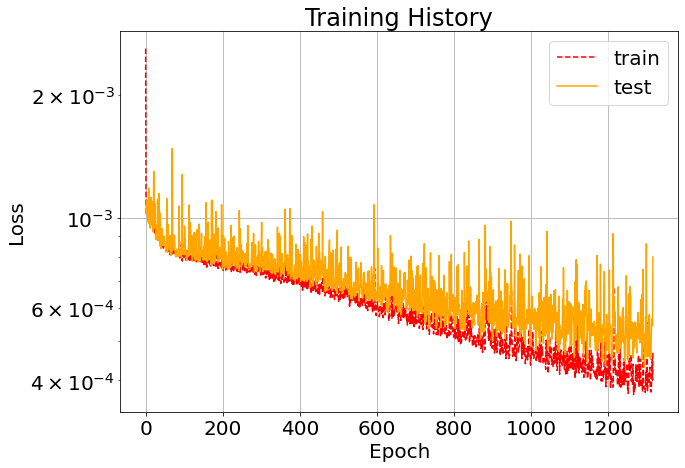

In [8]:
plt.figure(figsize=(10,7))
plt.semilogy(training.history['loss'], ls='--', color='red', label='train')
plt.semilogy(training.history['val_loss'], color='orange', label='test')
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training History")
plt.legend()
plt.show()

### 6. Predict EoS and compare with data

Evaluate model with validation data and de-normalize data and prediction.

In [9]:
x = x_vl
y = y_vl
pd = np.array(model(x))

# De-normalize data and prediction
pr = np.min(P) + (np.max(P) - np.min(P)) * pd
dt = np.min(P) + (np.max(P) - np.min(P)) * y

Choose a random $M-R$ curve and predict the corresponding EoS. Plot the predicted EoS and the data for comparison.

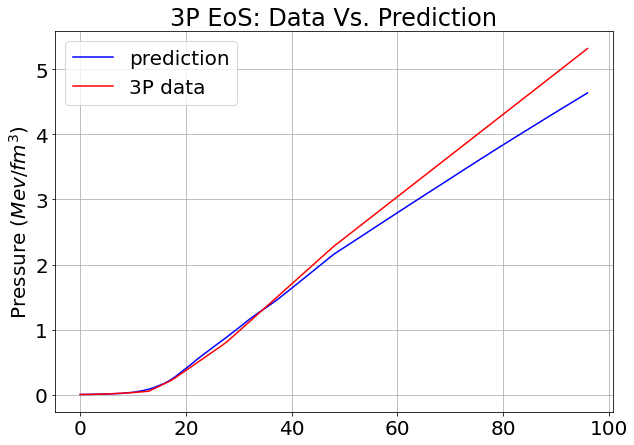

In [11]:
i = np.random.choice(x_vl.shape[0])

plt.figure(figsize=(10,7))
plt.plot(pr[i], color='blue', label='prediction')
plt.plot(dt[i], color='red', label='3P data')

plt.title("3P EoS: Data Vs. Prediction")
plt.ylabel("Pressure ($Mev/fm^3$)")
plt.legend()
plt.grid()
#plt.savefig(f"{FIGS}/real_vs_models.png")
plt.show()